In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib

### Load the dataset
- create dictionary for categorical values

In [55]:
incident_df = pd.read_excel('incident_dataset.xlsx', sheet_name='Sheet2')

incident_df['Exception']  = incident_df['Exception'].fillna('NA')
incident_df['CloudHealthIndex']  = incident_df['CloudHealthIndex'].fillna('NA')


incidentTypesDict = dict(zip(incident_df['Label'].unique(), np.arange(incident_df['Label'].unique().size)))
exceptionTypes = dict(zip(incident_df['Exception'].unique(), np.arange(incident_df['Exception'].unique().size)))
cloudHealthValues = dict(zip(incident_df['CloudHealthIndex'].unique(), np.arange(incident_df['CloudHealthIndex'].unique().size)))
features_vars = list(incident_df.columns.drop(['Label']).values)


print('incidentTypesDict  = ', incidentTypesDict, '\n')
print('exceptionTypes  = ', exceptionTypes, '\n')
print('cloudHealthValues  = ', cloudHealthValues, '\n')
print('features_vars  = ', features_vars, '\n')

incident_df.head()


incidentTypesDict  =  {'NetworkIssue': 0, 'NoIssue': 1, 'DatabaseConnection': 2, 'CommunityHealthIssue': 3, 'Community-FromtDoorNotaccessible': 4, 'InvoiceIssue': 5, 'UnsearchableWorkspaces': 6, 'DataLoad Failure': 7} 

exceptionTypes  =  {'spanning tree event': 0, 'NA': 1, 'JDBC-connection-permit-failure': 2, '[AWGenericException: java.lang.IllegalStateException, Export-webservice-ConnectionTimeout]': 3, '[ScheduledTsak-ArchesBatchPublishInThisRealm-Failure, Arches Schema version mismatch]': 4, '[OutOfMemoryException, GT Nodes restarting]': 5} 

cloudHealthValues  =  {'FAIR': 0, 'GOOD': 1, 'POOR': 2, 'NA': 3, 'CRITICAL': 4} 

features_vars  =  ['Date', 'AvgBackgroundQ', 'AvgThreadPoolSize', 'AvgWorkflowQ', 'CatalogSearchTime', 'IncreasingBGQueueTrend', 'IncreasingThreadTrend', 'IncreasingWFQueueTrend', 'Exception', 'LogSizeVolumePercent', 'NetworkConnectivitySNV-US1', 'IsProductReleased', 'UiNodeThreadsCount', 'CloudHealthIndex'] 



,Date,AvgBackgroundQ,AvgThreadPoolSize,AvgWorkflowQ,CatalogSearchTime,IncreasingBGQueueTrend,IncreasingThreadTrend,IncreasingWFQueueTrend,Exception,LogSizeVolumePercent,NetworkConnectivitySNV-US1,IsProductReleased,UiNodeThreadsCount,CloudHealthIndex,Label
0,2017-01-01 00:00:00,296.0,9.0,14.0,16.0,0,0,0,spanning tree event,39.0,1.0,1.0,13.0,FAIR,NetworkIssue
1,2017-01-01 00:30:00,284.0,9.0,8.0,15.0,0,0,0,spanning tree event,40.0,1.0,1.0,13.0,GOOD,NetworkIssue
2,2017-01-01 01:00:00,NaN,9.0,14.0,13.0,0,0,0,spanning tree event,26.0,1.0,0.0,19.0,POOR,NetworkIssue
3,2017-01-01 01:30:00,289.0,8.0,14.0,11.0,0,0,0,spanning tree event,39.0,1.0,0.0,12.0,NA,NetworkIssue
4,2017-01-01 02:00:00,304.0,10.0,10.0,10.0,0,0,0,spanning tree event,29.0,1.0,1.0,11.0,GOOD,NetworkIssue


### Create X and y datasets

In [56]:
# Get the y values from DataFram
X = incident_df[incident_df.columns.drop(['Label'])].copy()
y = incident_df['Label'].replace(incidentTypesDict)
# y.head()

### Split the dataset in Training and Test data

In [57]:
from sklearn.model_selection import train_test_split

test_data_size = 0.25
seed = 8

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_data_size, random_state=seed)
X_train.head()

,Date,AvgBackgroundQ,AvgThreadPoolSize,AvgWorkflowQ,CatalogSearchTime,IncreasingBGQueueTrend,IncreasingThreadTrend,IncreasingWFQueueTrend,Exception,LogSizeVolumePercent,NetworkConnectivitySNV-US1,IsProductReleased,UiNodeThreadsCount,CloudHealthIndex
374,2017-01-08 19:00:00,288.0,12.0,8.0,12.0,0,0,0,NA,30.0,0.0,0.0,10.0,POOR
694,2017-01-15 11:00:00,288.0,10.0,8.0,10.0,0,0,0,NA,30.0,0.0,0.0,16.0,GOOD
319,2017-01-07 15:30:00,304.0,8.0,9.0,10.0,0,0,0,NA,25.0,0.0,0.0,19.0,GOOD
933,2017-01-20 10:30:00,1745.0,70.0,71.0,35.0,0,0,0,NA,33.0,0.0,1.0,200.0,POOR
368,2017-01-08 16:00:00,305.0,9.0,12.0,11.0,0,0,0,NA,31.0,0.0,0.0,15.0,POOR


### Create a pre-processor to clean and create new features from dataset

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class IncidentPreprocessor(BaseEstimator, TransformerMixin):
    """Custom Preprocessing Estimator for the custom case
    
    """
    
    def __init___(self):
        pass
    
    def transform(self, df):

        exceptionTypes  =  {'spanning tree event': 0, 'NA': 1, 'JDBC-connection-permit-failure': 2, '[AWGenericException: java.lang.IllegalStateException, Export-webservice-ConnectionTimeout]': 3, '[ScheduledTsak-ArchesBatchPublishInThisRealm-Failure, Arches Schema version mismatch]': 4, '[OutOfMemoryException, GT Nodes restarting]': 5} 

        cloudHealthValues  =  {'FAIR': 0, 'GOOD': 1, 'POOR': 2, 'NA': 3, 'CRITICAL': 4} 

        features_vars  =  ['Date','AvgBackgroundQ', 'AvgThreadPoolSize', 'AvgWorkflowQ', 'CatalogSearchTime', 'IncreasingBGQueueTrend', 
                           'IncreasingThreadTrend', 'IncreasingWFQueueTrend', 'Exception', 'LogSizeVolumePercent', 'NetworkConnectivitySNV-US1', 
                           'IsProductReleased', 'UiNodeThreadsCount', 'CloudHealthIndex'] 
        
        df = df[features_vars]
        
        # Make all negative values to NaN so that it can be replaced with single value
        df['AvgBackgroundQ'][df['AvgBackgroundQ'] < 1] = np.NAN
        df['AvgThreadPoolSize'][df['AvgThreadPoolSize'] < 1] = np.NAN
        df['AvgWorkflowQ'][df['AvgWorkflowQ'] < 1] = np.NAN
        df['CatalogSearchTime'][df['CatalogSearchTime'] < 1] = np.NAN
        df['UiNodeThreadsCount'][df['UiNodeThreadsCount'] < 1] = np.NAN
        
        df = df.fillna(-999)
        
        df1 = df.apply(lambda rec : pd.Series({'Day' : rec['Date'].day, 
                      'Month' : rec['Date'].month, 
                      'Year' :  rec['Date'].year,
                      'Hour' : rec['Date'].hour, 
                      'Minute' : rec['Date'].minute, 
                      'Second' :  rec['Date'].second,
                      'DayOfYear' : rec['Date'].dayofyear, 
                      'DayOfWeek' : rec['Date'].dayofweek, 
                      'WeekOfYear' :  rec['Date'].weekofyear,
                      'WeekOfYear' : rec['Date'].weekofyear, 
                      'Quarter' : rec['Date'].quarter,
                      'IsWeekend' : int(rec['Date'].dayofweek > 4), 
                      'IsMonthStart' : int(rec['Date'].is_month_start),
                      'IsMonthEnd' :  int(rec['Date'].is_month_end)
                     }), axis = 1)
        
        df = pd.concat([df, df1], axis=1)

        df.replace({'CloudHealthIndex': cloudHealthValues}, inplace=True)
        df.replace({'Exception': exceptionTypes}, inplace=True)
        
        df = df[df.columns.drop(['Date'])]
        return df  #.as_matrix()
    
    def fit(self, df, y=None, **fit_params):
        
        return self;

# Model Selection and Evaluation

Model considered

1. Logistic Regression <br>
<br>
2. K-Nearest Neighbours <br>
<br>
3. Support Vector Machines <br>
<br>
4. Tree Based Models
    - Decision Tree
    - Random Forests
    - Gradient Boosting Tree


## Our Model Selection Criteria

### Goal of the system

> **We detect incidents accurately, reliably and intelligently**

In a nutshell, we want to identify incidents precisely i.e. less false positives 

and reliably i.e. no incidents will be spared so less false negatives. 

<hr>
So Model Selection criteria is
  - High Precision and 
  - High Recall. 
    
Recall can be compromized as there is process to detect it manually

Precision = TP / (TP + FP)


Recall = TP / (TP + FN)

F1 Score = 2 . (Precision . Recall) / (Precision + Recall)

### Model Selection Metrics

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import pickle
import dill as pickle

from sklearn.externals import joblib

def show_model_metrics(algo,grid, y_test, y_preds):
    prf_score = precision_recall_fscore_support(y_test, y_preds, average='macro')
    print('\n', algo, ' Classifier best estimator parameters are : \n', grid.best_estimator_)
    print('\n', algo, ' Classifier best score : {:.3f} '.format(grid.best_score_))
    print('\n', algo, ' Classifier Confusion Matrix:\n',confusion_matrix(y_test, y_preds))
    print('\n', algo, ' Classifier Classification Report:\n', classification_report(y_test, y_preds))
    print('\n', algo, ' Classifier Precision, Recall, F1-Score, Support (Macro):\n', prf_score)
    print('\n', algo, ' Classifier Accuracy Score: {:.3f}\n'.format(accuracy_score(y_test, y_preds)))
    
    # multi class format is not supported
#     print('\n', algo, ' Classifier ROC AUC Score: {:.3f}\n'.format(roc_auc_score(y_test, y_preds, average='macro')))
    
    # add accuracy to tuple
    prf_score = *prf_score[:-1] , accuracy_score(y_test, y_preds)
    
    return prf_score


def save_model(filename, model):
    # save the model
#     with open('models/'+filename, 'wb') as file:
#         pickle.dump(model, file)
    joblib.dump(model,'models/'+filename)

## Algorithms Evaluation


Let's evaluate different alorithms

### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

lgr_params = {
    'logisticregression__penalty' : ['l2'],
    'logisticregression__C' : [0.001,0.01,0.1,1,10,100],
    'logisticregression__n_jobs' : [-1],
    'logisticregression__random_state' : [24]
}

lgr_pipe = make_pipeline(IncidentPreprocessor(), StandardScaler(), LogisticRegression())

lgr_grid = GridSearchCV(lgr_pipe, param_grid=lgr_params, cv=3)

In [71]:

lgr_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logisticregression__n_jobs': [-1], 'logisticregression__random_state': [24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
y_preds = lgr_grid.best_estimator_.predict(X_test)

lgr_scores = show_model_metrics('Logistic Regression', lgr_grid, y_test, y_preds)


 Logistic Regression  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=24, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

 Logistic Regression  Classifier best score : 0.970 

 Logistic Regression  Classifier Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0   9   0   2   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   4   0   2   2]
 [  0   0   0   0   0   0   1   7]]

 Logistic Regression  Classifier Classification Report:
              precision    recall  f

In [75]:
# save the model
save_model('model_logistic_reg_v1.mod', lgr_grid)

### K-Nearest Neighbours

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
#     'kneighborsclassifier__n_neighbors' : [5,6,7,8],
    'kneighborsclassifier__n_jobs' : [-1]
}

knn_pipe = make_pipeline(IncidentPreprocessor(), KNeighborsClassifier())

knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params, cv=3)


In [77]:
knn_grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kneighborsclassifier__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
y_preds = knn_grid.best_estimator_.predict(X_test)

knn_scores = show_model_metrics('K-NN', knn_grid, y_test, y_preds)


 K-NN  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))])

 K-NN  Classifier best score : 0.914 

 K-NN  Classifier Confusion Matrix:
 [[  4   1   0   0   0   0   0   0]
 [  2 196   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0   5   0   4   2]
 [  0   0   0   0   0   6   0   0]
 [  0   3   0   0   3   0   2   0]
 [  0   1   0   0   3   0   3   1]]

 K-NN  Classifier Classification Report:
              precision    recall  f1-score   support

          0       0.67      0.80      0.73         5
          1       0.98      0.99      0.98       198
          2       1.00      1.00      1.00        10
          3       1.00      1.00      1.00         7
   

In [79]:
# save the model
save_model('model_knn_v1.mod', knn_grid)

### Support Vector Machines

In [80]:
from sklearn.svm import SVC

svc_params = {
    'svc__C' : [0.001,0.01,0.1,1,10,100],
    'svc__kernel' : ['linear']
}

svc_pipe = make_pipeline(IncidentPreprocessor(), SVC())

svc_grid = GridSearchCV(svc_pipe, svc_params, cv=3)

In [81]:
svc_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svc__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
y_preds = svc_grid.best_estimator_.predict(X_test)

svc_scores = show_model_metrics('SVM', svc_grid, y_test, y_preds)


 SVM  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('svc', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

 SVM  Classifier best score : 0.971 

 SVM  Classifier Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  2 196   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   6   1   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   1   0   6   1]
 [  0   0   0   0   0   0   1   7]]

 SVM  Classifier Classification Report:
              precision    recall  f1-score   support

          0       0.71      1.00      0.83         5
          1       1.00      0.99      0.99       198
          2       1.00      1.00      1.00        10
          3   

In [83]:
# save the model
save_model('model_svm_v1.mod', svc_grid)

### Random Forest Classifiers

In [84]:
from sklearn.ensemble import RandomForestClassifier

random_forests_params = {
#         "randomforestclassifier__n_estimators" : [10, 20, 30],
#         "randomforestclassifier__max_depth" : [None, 6, 8, 10],
#         "randomforestclassifier__max_leaf_nodes": [None, 5, 10, 20], 
#         "randomforestclassifier__min_impurity_split": [0.1, 0.2, 0.3],
        # run parallel as per cores available
        "randomforestclassifier__n_jobs" : [-1]}

pipe = make_pipeline(IncidentPreprocessor(), RandomForestClassifier())

random_forests_grid = GridSearchCV(pipe, param_grid=random_forests_params, cv=3)

In [85]:

random_forests_grid.fit(X_train,y_train)
# warnings.filterwarnings("ignore")

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
      ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
y_preds = random_forests_grid.best_estimator_.predict(X_test)

random_forests_scores = show_model_metrics('Random Forests', random_forests_grid, y_test, y_preds)


 Random Forests  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
      ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

 Random Forests  Classifier best score : 0.995 

 Random Forests  Classifier Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   0   0   8   0]
 [  0   0   0   0   0   0   2   6]]

 Random Forests  Classifier Classification Report:
              precision    recall  f1-score   support

          0       1.

In [87]:
   
# save the model
save_model('model_random_forest_v1.mod', random_forests_grid)    

### Gradient Boosting Decision Tree

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt_params = {
#     'gradientboostingclassifier__min_samples_split' : [1200],
#     'gradientboostingclassifier__min_samples_leaf' :[50] ,
#     'gradientboostingclassifier__max_depth' : [5],
#     'gradientboostingclassifier__max_leaf_nodes' :[] ,
#     'gradientboostingclassifier__max_features' :[7],
#     'gradientboostingclassifier__random_state' :[10]
}

gbdt_pipe = make_pipeline(IncidentPreprocessor(), GradientBoostingClassifier())

gbdt_grid = GridSearchCV(gbdt_pipe, param_grid=gbdt_params, cv=3)

In [89]:
gbdt_grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decr...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
y_preds = gbdt_grid.best_estimator_.predict(X_test)

gbdt_scores = show_model_metrics('Gradient Boosting Decision Trees', gbdt_grid, y_test, y_preds)


 Gradient Boosting Decision Trees  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decr...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

 Gradient Boosting Decision Trees  Classifier best score : 0.995 

 Gradient Boosting Decision Trees  Classifier Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   0   0   8   0]
 [  0   0   0   0   0   0   0   8]]

 Gradient Boosting Decision Trees  Classifier Classification Report:
   

In [91]:
# save the model
save_model('model_gbdt_v1.mod', gbdt_grid)    

### XGBoost

In [92]:
from xgboost import XGBClassifier

xgb_params = {
#     'xgb__max_depth' : [3,5,7],
#     'xgb__min_child_depth' : [1,3,5],
    'xgbclassifier__n_jobs' : [-1]
}

xgb_pipe = make_pipeline(IncidentPreprocessor(), XGBClassifier())

xgb_grid = GridSearchCV(xgb_pipe, param_grid=xgb_params, cv=3)

In [93]:
xgb_grid.fit(X_train, y_train)
# warnings.filterwarnings("ignore")

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missin...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgbclassifier__n_jobs': [-1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [94]:
y_preds = xgb_grid.best_estimator_.predict(X_test)

xgb_scores = show_model_metrics('XGBoost', xgb_grid, y_test, y_preds)


 XGBoost  Classifier best estimator parameters are : 
 Pipeline(memory=None,
     steps=[('incidentpreprocessor', IncidentPreprocessor()), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

 XGBoost  Classifier best score : 0.999 

 XGBoost  Classifier Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0   6   0   0]
 [  0   0   0   0   0   0   8   0]
 [  0   0   0   0   0   0   0   8]]

 XGBoost  Classifier Classification Report:
              precision    recall  f1-scor

In [95]:
# save the model
save_model('model_xgb_v1.mod', xgb_grid) 

### Model Comparison

<IPython.core.display.Javascript object>


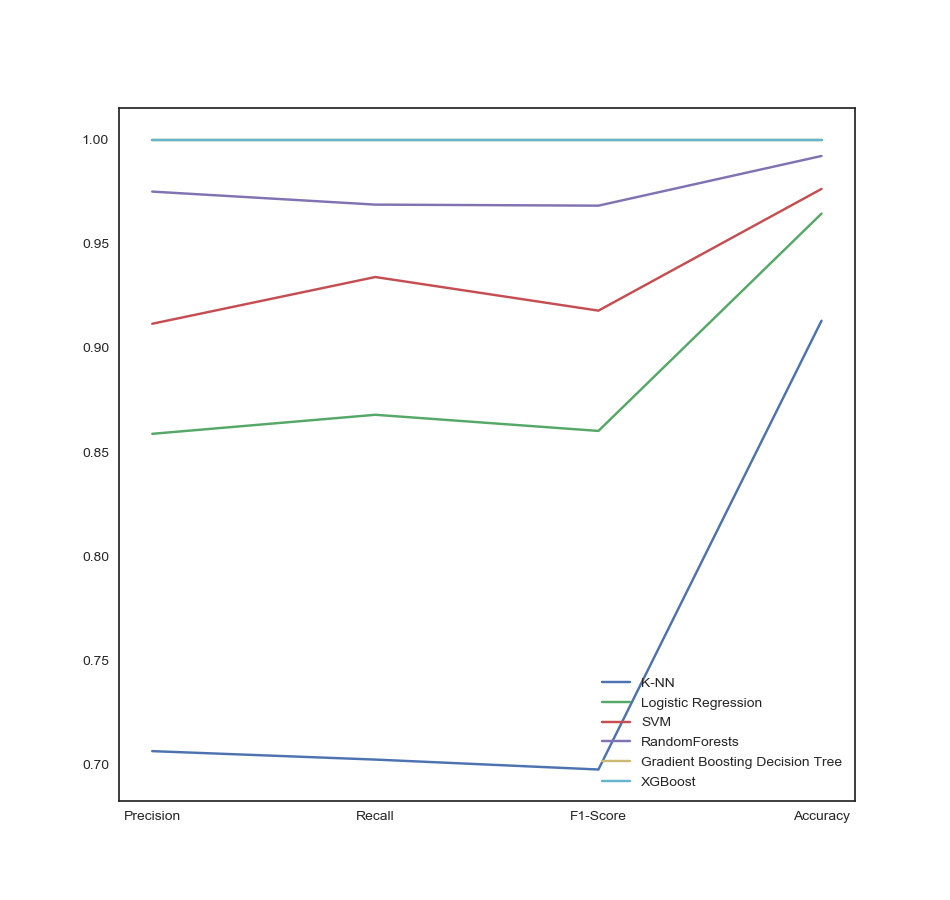

In [101]:
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')
%matplotlib notebook

fig1 = plt.figure(figsize=(9.5,9))

# plt.plot(xgb_scores[:-1],  kind='barh') #, x_ticks=['Precision', 'Recall', 'F1-Score'])

bar_height = 0,2
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
x = np.arange(4)


plt.plot(knn_scores)
plt.plot(lgr_scores)
plt.plot(svc_scores)
plt.plot(random_forests_scores)
plt.plot(gbdt_scores)
plt.plot(xgb_scores)

# plt.bar(x-0.2,  knn_scores,width=0.2 ,align='center', )
# plt.bar(x-0.1, lgr_scores,width=0.2 ,align='center',)
# plt.bar(x, random_forests_scores,width=0.2 ,align='center',)
# plt.bar(x+0.1, gbdt_scores,width=0.2,align='center',)
# plt.bar(x+0.2, xgb_scores, width=0.2,align='center',)

plt.xticks(x,metrics)
plt.legend(['K-NN', 'Logistic Regression', 'SVM', 'RandomForests', 'Gradient Boosting Decision Tree', 'XGBoost'])

fig1.savefig('model_comparison.png')

### Summary Analysis

Model metrics show **XgBoost** model to be better performing . 
- Also it has advatage in performance over GBDT and it's parallelizable
- extremely fast than GBDT / Random Forests
- parallelizable and distributed computing support